# Exploratory Data Analysis on Traffic Violations Issued in NYC 
**EDA Project for Jovian course - "Zero to Data Scientist"**   
**By: Samantha Roberts**    
**July 2021**

![New York City Parking Ticket (Credit: CBS 2)](https://newyork.cbslocal.com/wp-content/uploads/sites/14578484/2012/05/parking-ticket.jpg?w=420&h=316&crop=1)



# General Introduction to Open Government Data 
I am a fan of government having an "Open Data Protocol." This has become important at the city, state, and country levels in the US as well as around the world.  

In Decamber of 2007, [30 open government advocates](https://public.resource.org/open_government_meeting.html) from academia, industry, and government convened in Sebastopol, California, to discuss why "open data" was essential to democracy.  The participants at this meeting developed a set of [8 Open Government Data Principles](https://public.resource.org/8_principles.html).   Namely government data shall be considered open if it is:

1. Complete (All data is made available without limitation)
2. Primary (collected at the source with high granularity)
3. Timely (Made available as quickly as possible)
4. Accessible (Available to a wide range of users)
5. Machine Processable (Reasonaby structured for automation)
6. Non-discriminatory (Available to all - no requirement for regristration)
7. Non-proprietary (Data has format where no entity has exclusive control)
8. License-free (Data not subject to copyright, trademark or regulation)

In 2012 under Mayor Bloomberg the [NYC Open Data](https://opendata.cityofnewyork.us/data/) repository was launched.  This is an amazing compelation of data sets which is continously updated and supported, and supplies public data about all facets of the city, including police activity, budgets, business, city government, education, environment, and health information (recently including extensive COVID data).  

# NYC Parking Violation Data
One of the data sets in the NYC Open Data repository is from the Department of Finance on all of the Parking violations that are issued annually.  I found this data on Kaggle before I explored the NYC Open Data site.  

### I found this an interesting data set for analysis for the following reasons:

1. It is large.  Currently there are over 10 million parking tickets issued each year throught the five boroughs of Brooklyn, Bronx, Queens, Staten Island, and Manhattan.  [Kaggle]((https://www.kaggle.com/new-york-city/ny-parking-violations-issued) has packaged data from 2014-2017 inclusive, ([actually, in two locations](https://www.kaggle.com/new-york-city/nyc-parking-tickets)), but the same data is available directly through [NY Open Data](https://opendata.cityofnewyork.us/). Direct [Links](#CSVLinks) to the CSV files up to 2021 are provided at the end of this notebook.  
2. There are at least 43 features of each ticket, with include information about the vehicle, the registrataion, the type of violation, the location, the borough and precinct, the steet, the rank and division of the ticket issuer.  This seemed especially rich for investigation.
3. Because of the size, we needed to employ methods to reduce the data size and improve the processing time (such as Google Colab and Dask) to undertake this analysis in an efficient way.
3. The data includes date and time information which lends itself to correlation with external events in the city, and gives experience working with time series.
4. The geographc information lends itself to the creation of maps incorperating the various data. (Along with working with geoJSON files of NYC police precincts)

### This data is difficult for the following reasons:
1. Though the columns are well labled with descriptive names, there are several columns with catagorical information in the form of abreviations that are not well explained.  However, this lends itself to pulling external files and scraping data to include in the analysis and further describe the data.
2. It is also difficult because it is large.  Not so much from a computational standpoint, but with respect to choosing and limiting the relevant data that I can analyze in the time available.  

# [xxx] The Methodology 
This particular dataset lends itself to a perfect EDA project as it has the following elements:
- The data needs to be cleaned, and decisions need to be made -- many parking tickets are not written correctly, and therefore not all fields are filled out
- another challenging thing is that there is no table that explains the values in each column... and not all columns are filled out.  for instance there are three columns that relate to the precinct the ticket was issued in namely (with the number of unique values):
>Violation Location :  78  
Violation Precinct :  79   
Issuer Precinct :  111  
- there is a date and time the ticket is issues, and working with time series is something that is fun to demonstrate. 
- there is location information which allows exploration in geopandas and folium
- there are many questions that can be asked which would link to other data sets being imported

### Must Have Items
- We will take a random sample of 10,000 tickets from the data of one year of parking tickets, namely 2017
- We will write the code to do the analysis for this sample and then try to apply it to the entire year of data
- Will incorperate other data sets such as fine amaounts

### Would be nice for later Items
- We wil then see about applying this analysis to the other years of data that are available directly from the NYC data site
- may include scraping the data
- We will apply some compression to handle that large scale of data -- have no clue about that right now
- Will furthere improve ad convert addresses to lat long and see if we can incorperate folium maps with precinct boundaries





In [2]:
project_name = 'nyc-parking-2017-final'
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/samantha-roberts/nyc-parking-2017-final


'https://jovian.ai/samantha-roberts/nyc-parking-2017-final'

In [3]:
!pip install jovian opendatasets pandas numpy seaborn plotly matplotlib pyarrow folium --quiet 

In [4]:
!pip install plotly --upgrade --quiet 

     |████████████████████████████████| 20.6MB 1.5MB/s 


In [5]:
!pip install "dask[dataframe]" --upgrade --quiet

     |████████████████████████████████| 983kB 4.2MB/s 
     |████████████████████████████████| 122kB 44.8MB/s 


In [6]:
import jovian
import opendatasets as od
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import pyarrow.feather as feather
import os
import folium
import dask.dataframe as dd
%matplotlib inline

In [7]:
sns.set_style('darkgrid') # white grid on darker background
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000' #makes the figure background white

# STEP 1: Downloading the Data <a id="section1"></a>

In [8]:
%%time
nyc_traffic_violations_url = 'https://www.kaggle.com/new-york-city/nyc-parking-tickets?select=Parking_Violations_Issued_-_Fiscal_Year_2017.csv'
od.download(nyc_traffic_violations_url, force=False)

  0%|          | 0.00/2.02G [00:00<?, ?B/s]

100%|██████████| 2.02G/2.02G [00:54<00:00, 40.2MB/s]



CPU times: user 1min 2s, sys: 19.5 s, total: 1min 22s
Wall time: 2min 5s


In [9]:
os.listdir('./nyc-parking-tickets') # let us see what was downloaded

['Parking_Violations_Issued_-_Fiscal_Year_2017.csv',
 'Parking_Violations_Issued_-_Fiscal_Year_2014__August_2013___June_2014_.csv',
 'Parking_Violations_Issued_-_Fiscal_Year_2015.csv',
 'Parking_Violations_Issued_-_Fiscal_Year_2016.csv']

In [10]:
path = './nyc-parking-tickets/Parking_Violations_Issued_-_Fiscal_Year_2017.csv'

In [11]:
%%time
raw_df = pd.read_csv(path, dtype={'Issuer Squad': 'str', 'Violation Post Code': 'str'}) # reduce high memory because these 2 columns have mixed types

CPU times: user 49.6 s, sys: 9.46 s, total: 59.1 s
Wall time: 58.7 s


In [12]:
raw_df

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
0,5092469481,GZH7067,NY,PAS,07/10/2016,7,SUBN,TOYOT,V,0,0,0,0,NaN,0,0,0,NaN,NaN,0143A,NaN,BX,NaN,NaN,ALLERTON AVE (W/B) @,BARNES AVE,0,1111,D,T,NaN,NaN,NaN,GY,NaN,2001,NaN,0,NaN,FAILURE TO STOP AT RED LIGHT,NaN,NaN,NaN
1,5092451658,GZH7067,NY,PAS,07/08/2016,7,SUBN,TOYOT,V,0,0,0,0,NaN,0,0,0,NaN,NaN,0400P,NaN,BX,NaN,NaN,ALLERTON AVE (W/B) @,BARNES AVE,0,1111,D,T,NaN,NaN,NaN,GY,NaN,2001,NaN,0,NaN,FAILURE TO STOP AT RED LIGHT,NaN,NaN,NaN
2,4006265037,FZX9232,NY,PAS,08/23/2016,5,SUBN,FORD,V,0,0,0,0,NaN,0,0,0,NaN,NaN,0233P,NaN,BX,NaN,NaN,SB WEBSTER AVE @ E 1,94TH ST,0,1111,C,T,NaN,NaN,NaN,BK,NaN,2004,NaN,0,NaN,BUS LANE VIOLATION,NaN,NaN,NaN
3,8478629828,66623ME,NY,COM,06/14/2017,47,REFG,MITSU,T,10610,34330,34350,20180630,14.0,14,14,359594,T102,J,1120A,NaN,NY,O,330,7th Ave,NaN,0,408,l2,NaN,Y,0700A,0700P,WH,NaN,2007,NaN,0,04,47-Double PKG-Midtown,NaN,NaN,NaN
4,7868300310,37033JV,NY,COM,11/21/2016,69,DELV,INTER,T,10510,34310,34330,20170228,13.0,13,13,364832,T102,M,0555P,NaN,NY,F,799,6th Ave,NaN,0,408,h1,NaN,Y,0700A,0700P,WHITE,NaN,2007,NaN,0,31 6,69-Failure to Disp Muni Recpt,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10803023,1415891400,HGK6453,NJ,PAS,11/02/2068,21,SDN,HONDA,S,17380,5780,5880,0,68.0,68,0,582845,KS10,0000,1207P,NaN,K,F,715,BAY RIDGE AVE,NaN,0,408,D1,NaN,BBYBBBB,1130A,0100P,BLACK,0.0,0,-,0,NaN,NaN,NaN,NaN,NaN
10803024,1384716543,GRA6240,NY,PAS,07/12/2069,20,SUBN,TOYOT,X,93830,64830,23330,20161001,71.0,71,976,100519,0976,0000,0750A,NaN,K,F,444,WINTHROP STREET,NaN,0,408,D,NaN,BBBBBBB,ALL,ALL,GRAY,0.0,2007,-,0,NaN,NaN,NaN,NaN,NaN
10803025,1413536554,RC8S28,PA,PAS,08/14/2069,46,SUBN,NaN,P,37980,14080,14130,20160930,69.0,69,69,949860,0069,0000,1150A,NaN,K,F,1285,E 94 ST,NaN,0,408,J2,NaN,BBBBBBB,ALL,ALL,RED,0.0,0,-,0,NaN,NaN,NaN,NaN,NaN
10803026,1415514203,HGU9544,NY,PAS,11/15/2069,40,SUBN,JEEP,P,0,5530,0,20180624,69.0,69,69,935065,0069,0000,0319A,NaN,K,F,37,PAERDERGAT,4 ST,0,408,E2,NaN,BBBBBBB,ALL,ALL,BROWN,0.0,2011,-,0,NaN,NaN,NaN,NaN,NaN


# STEP 2: Data Prep and Cleaning

In [13]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10803028 entries, 0 to 10803027
Data columns (total 43 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   Summons Number                     int64  
 1   Plate ID                           object 
 2   Registration State                 object 
 3   Plate Type                         object 
 4   Issue Date                         object 
 5   Violation Code                     int64  
 6   Vehicle Body Type                  object 
 7   Vehicle Make                       object 
 8   Issuing Agency                     object 
 9   Street Code1                       int64  
 10  Street Code2                       int64  
 11  Street Code3                       int64  
 12  Vehicle Expiration Date            int64  
 13  Violation Location                 float64
 14  Violation Precinct                 int64  
 15  Issuer Precinct                    int64  
 16  Issuer Code     

In [14]:
cols_to_keep =['Registration State',
               'Plate Type',
               'Issue Date',
               'Violation Time',
               'Violation Location',
               'Violation Precinct', 
               'Issuer Precinct',
               'Issuer Code',
               'Violation Code',
               'Meter Number',
               'Violation County',
               'Issuer Squad',
               'Issuing Agency']

In [15]:
df = raw_df[cols_to_keep].copy() # making a copy detaches this from the origional sample_df and raw_df
df

,Registration State,Plate Type,Issue Date,Violation Time,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Violation Code,Meter Number,Violation County,Issuer Squad,Issuing Agency
0,NY,PAS,07/10/2016,0143A,NaN,0,0,0,7,NaN,BX,NaN,V
1,NY,PAS,07/08/2016,0400P,NaN,0,0,0,7,NaN,BX,NaN,V
2,NY,PAS,08/23/2016,0233P,NaN,0,0,0,5,NaN,BX,NaN,V
3,NY,COM,06/14/2017,1120A,14.0,14,14,359594,47,NaN,NY,J,T
4,NY,COM,11/21/2016,0555P,13.0,13,13,364832,69,NaN,NY,M,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10803023,NJ,PAS,11/02/2068,1207P,68.0,68,0,582845,21,-,K,0000,S
10803024,NY,PAS,07/12/2069,0750A,71.0,71,976,100519,20,-,K,0000,X
10803025,PA,PAS,08/14/2069,1150A,69.0,69,69,949860,46,-,K,0000,P
10803026,NY,PAS,11/15/2069,0319A,69.0,69,69,935065,40,-,K,0000,P


### Three of these columns look  like they have similar information

In [16]:
precinct_loc_df = df[['Violation Location', 'Violation Precinct', 'Issuer Precinct']]
precinct_loc_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Violation Location,8730628.0,55.696755,37.944333,1.0,19.0,50.0,90.0,933.0
Violation Precinct,10803028.0,45.012163,40.552560,0.0,7.0,33.0,78.0,933.0
Issuer Precinct,10803028.0,46.829312,62.667036,0.0,1.0,28.0,78.0,997.0


In [17]:
precinct_loc_df.nunique()

Violation Location    212
Violation Precinct    213
Issuer Precinct       655
dtype: int64

**Let us plot the correlation to see if the columns are as related as it appears**

In [18]:
precinct_loc_df.corr()

,Violation Location,Violation Precinct,Issuer Precinct
Violation Location,1.000000,1.000000,0.542733
Violation Precinct,1.000000,1.000000,0.617624
Issuer Precinct,0.542733,0.617624,1.000000


In [19]:
px.imshow(precinct_loc_df.corr()) 

**They are duplicated - let us drop Violation Precinct as the oly difference is '0''s which is not a valid precinct number**

In [20]:
df.drop('Violation Precinct', axis=1, inplace=True)

**Meanwhile the 'Issuer Precinct has many more values** 
- Perhaps later we can correlate these with the 'Issuer Squad'



### Get the date and time into proper datetime format
- Merge the two columns
- format for time conversion -- add 'M' to put into std 'AM' and 'PM' format
- convert to Datetime format

In [21]:
%%time
df['Issue Date and Time'] = df['Issue Date'] + ' ' + df['Violation Time']
df['Issue Date and Time'] = df['Issue Date and Time'] + 'M'
df['Issue Date and Time'] = pd.to_datetime(df['Issue Date and Time'], format='%m/%d/%Y %I%M%p', errors='coerce')

CPU times: user 38.7 s, sys: 1.48 s, total: 40.2 s
Wall time: 39.6 s


In [22]:
df['Issue Date and Time']

0          2016-07-10 01:43:00
1          2016-07-08 16:00:00
2          2016-08-23 14:33:00
3          2017-06-14 11:20:00
4          2016-11-21 17:55:00
                   ...        
10803023   2068-11-02 12:07:00
10803024   2069-07-12 07:50:00
10803025   2069-08-14 11:50:00
10803026   2069-11-15 03:19:00
10803027   2069-11-19 08:43:00
Name: Issue Date and Time, Length: 10803028, dtype: datetime64[ns]

**Let us see how many date times errors caused NaT values**

In [23]:
df['Issue Date and Time'].isna().sum()

58838

**How big of a percentage of the data is this?  (Do we need to be concerned?) Compute percentage**

In [24]:
df['Issue Date and Time'].isna().sum()/df.shape[0] * 100

0.544643594370023

**only 0.54% -- we can let this go**
- these are mostly caused by the entries with time = 00XXAM which is a 24 hour format in pandas datetime 
- these should be 12XXAM in the 12 hour format
- [xxx] Can come back and preprocess these so I do not loose these values

**Let us drop the old date and Time columns (for now)**

In [25]:
df.drop(['Violation Time', 'Issue Date'], axis=1, inplace=True)
df.head(3)

,Registration State,Plate Type,Violation Location,Issuer Precinct,Issuer Code,Violation Code,Meter Number,Violation County,Issuer Squad,Issuing Agency,Issue Date and Time
0,NY,PAS,NaN,0,0,7,NaN,BX,NaN,V,2016-07-10 01:43:00
1,NY,PAS,NaN,0,0,7,NaN,BX,NaN,V,2016-07-08 16:00:00
2,NY,PAS,NaN,0,0,5,NaN,BX,NaN,V,2016-08-23 14:33:00


### Now let us clean up the violation county column
- There are only 5 counties in NYC -- let us group all of these

In [26]:
df['Violation County'].unique()

array(['BX', 'NY', 'QN', 'K', 'Q', 'R', 'BK', 'ST', 'MN', nan, 'BRONX',
       'QNS', 'KINGS'], dtype=object)

In [27]:
df['Violation County'].value_counts()

NY       3433026
K        2218843
Q        1838985
BX       1362463
BK        880657
QN        674245
ST        137542
R         121416
MN         96298
KINGS          2
BRONX          2
QNS            2
Name: Violation County, dtype: int64

In [28]:
df[df['Violation County'].isin(['KINGS', 'QNS', 'BRONX'])]

,Registration State,Plate Type,Violation Location,Issuer Precinct,Issuer Code,Violation Code,Meter Number,Violation County,Issuer Squad,Issuing Agency,Issue Date and Time
1294039,NY,PAS,41.0,67,311404,14,-,BRONX,0000,P,2017-03-02 21:35:00
3853217,NY,PAS,108.0,0,568677,40,-,QNS,0000,X,2016-10-07 07:45:00
4684445,NY,PAS,41.0,67,311404,14,-,BRONX,0000,P,2016-09-20 13:40:00
9904658,NY,COM,84.0,674,944552,14,-,KINGS,0000,P,2016-09-29 13:45:00
10213529,NY,PAS,NaN,820,920348,40,-,QNS,0000,F,2017-02-24 10:57:00
10538928,NY,PAS,84.0,674,944552,20,-,KINGS,0000,P,2016-10-19 13:21:00


In [29]:
remap_county_dict = {
    'K' : 'Brooklyn',
    'Q' : 'Queens',
    'NY': 'Manhattan',
    'QN': 'Queens',
    'BK': 'Brooklyn',
    'R' : 'Staten Island',
    'BX': 'Bronx',
    'ST': 'Staten Island',
    'MN': 'Manhattan',
    'KINGS': 'Brooklyn',
    'QNS': 'Queens',
    'BRONX': 'Bronx'
}
df['Violation County'] = df['Violation County'].map(remap_county_dict).astype('category')
df.head(3)

,Registration State,Plate Type,Violation Location,Issuer Precinct,Issuer Code,Violation Code,Meter Number,Violation County,Issuer Squad,Issuing Agency,Issue Date and Time
0,NY,PAS,NaN,0,0,7,NaN,Bronx,NaN,V,2016-07-10 01:43:00
1,NY,PAS,NaN,0,0,7,NaN,Bronx,NaN,V,2016-07-08 16:00:00
2,NY,PAS,NaN,0,0,5,NaN,Bronx,NaN,V,2016-08-23 14:33:00


**We have successfully grouped the counties int 5 catagories**

In [30]:
df['Violation County'].isna().sum()

39547

In [31]:
df['Violation County'].unique()

['Bronx', 'Manhattan', 'Queens', 'Brooklyn', 'Staten Island', NaN]
Categories (5, object): ['Bronx', 'Manhattan', 'Queens', 'Brooklyn', 'Staten Island']

# STEP 3: Ask questions and answer them using EDA and Visualization

# Q1 - What is the distribution of tickets across the 5 boroughs for the year?

In [32]:
#jovian.commit(project=project_name)

In [33]:
county_totals_df = pd.DataFrame(df['Violation County'].value_counts())
county_totals_df

,Violation County
Manhattan,3529324
Brooklyn,3099502
Queens,2513232
Bronx,1362465
Staten Island,258958


**This is less than 1/2% of the total data -- perhaps can later be infered via the precinct**

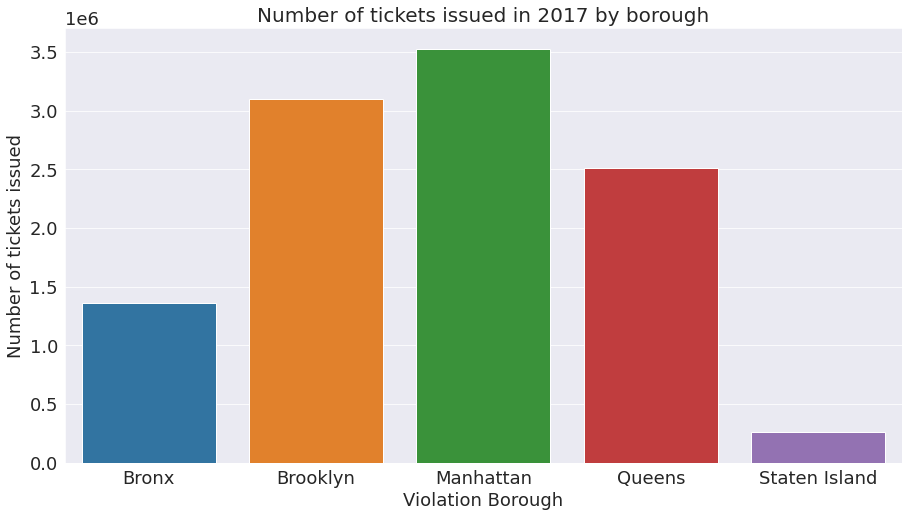

In [34]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x="Violation County", data=df)
plt.title('Number of tickets issued in 2017 by borough', fontsize=20);
plt.xlabel('Violation Borough', fontsize=18)
plt.ylabel('Number of tickets issued', fontsize=18);

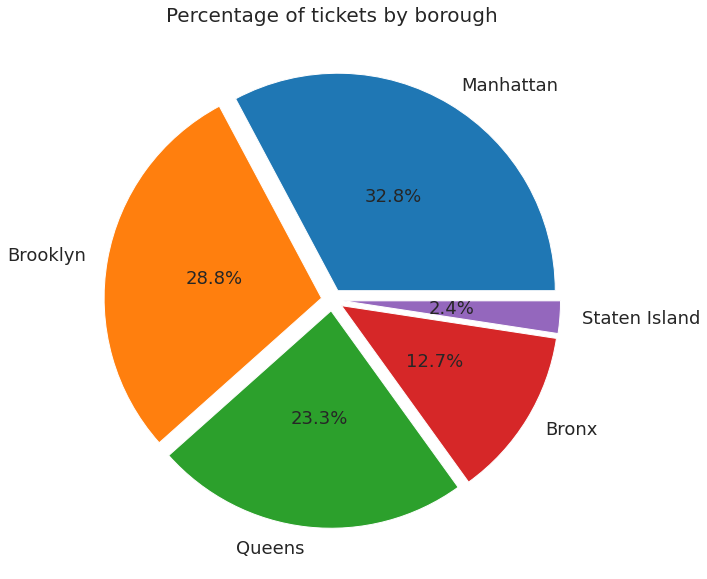

In [35]:
pie, ax = plt.subplots(figsize=[10,10])
plt.pie(x=county_totals_df['Violation County'], autopct="%.1f%%", explode=[0.05]*5, labels=county_totals_df.index, pctdistance=0.5)
plt.title("Percentage of tickets by borough", fontsize=20);

## The largest ticket issuer is Manhattan and the lowest is Staten Island  
- Manhattan is one of the most densly populated areas of NYC with over 71,000 people per square mile and private parking garages costing several hundered and even thousands per month
- Staten Island is a more rural borough of NYC, with a population density of just over 8,000 people per square mile.  Many of the homes are houses with driveways and garages and shopping centers often have parking lots -- all features whih are absent in the other boroughs of NYC



---



#Q2 - What is the distribution of tickets across the precincts? 

For each county lets check the Violation Location and see if that matches the data I have from the NYT
https://www.nytimes.com/2017/03/17/nyregion/nypd-precincts.html
According to the New York Police Department’s public information office, the current range of precinct numbers for each borough is as follows:
- **1-34 Manhattan**
- **40-52 Bronx**
- **60-94 Brooklyn**  
- **100-115 Queens**  
- **120-123 Staten Island**


>And not all precincts have numbers:   
The 22nd Precinct is now the Central Park Precinct;   
the 14th Precinct is now Midtown South;   
and the 18th Precinct is now Midtown North.  

### We will now:
- Make a list of the counties to loop over
- print out the prencincts associated with those counties
- see that they are appropriate for the above list

In [36]:
#jovian.commit(project=project_name)

**There are over 2 Million NaN entries for the Precinct info**

In [37]:
df['Violation Location'].isna().sum()

2072400

**We can also see that there are a lot of precincts in each county that are not valid numbers**

In [38]:
counties = list(df['Violation County'][~df['Violation County'].isnull()].unique())
for county in counties:
    print('The number of precints in {} data are: {}'.format(county, 
                                              #np.sort(df['Violation Location'][df['Violation County'] == county].unique())))
                                              df['Violation Location'][df['Violation County'] == county].nunique()))

The number of precints in Bronx data are: 109
The number of precints in Manhattan data are: 145
The number of precints in Queens data are: 98
The number of precints in Brooklyn data are: 131
The number of precints in Staten Island data are: 85


**So we have a lot of values that are not standard precinct numbers**
- These may be atributed to tickets issued by non-police people, such as MTA or Parking or court departments (with their own codes?)
- For now let us get the police precincts that are valid and plot only those
- We see below that the majority of the tickets are in valid precincts for the particular borough

**Let us get the precinct GeoJson from the NYC Open Data website and extract all of the valid precinct numbers**
- The precinct boundaries are available on NYC open data https://data.cityofnewyork.us/Public-Safety/Police-Precincts/78dh-3ptz


In [39]:
import json
from urllib.request import urlopen

precinct_geo = 'https://data.cityofnewyork.us/api/geospatial/78dh-3ptz?method=export&format=GeoJSON'

with urlopen(precinct_geo) as response:
    precincts = json.load(response)

In [40]:
precincts['features'][0]['properties']

{'precinct': '1', 'shape_area': '47315893.6803', 'shape_leng': '80969.424461'}

**Here is a list of the valid precinct numbers**
- They appear to be stored as strings

In [41]:
feature_id_list = []
for index in range(len(precincts['features'])):
    feature_id_list.append(precincts['features'][index]['properties']['precinct'])
np.sort(feature_id_list)

array(['1', '10', '100', '101', '102', '103', '104', '105', '106', '107',
       '108', '109', '110', '111', '112', '113', '114', '115', '120',
       '121', '122', '123', '13', '14', '17', '18', '19', '20', '22',
       '23', '24', '25', '26', '28', '30', '32', '33', '34', '40', '41',
       '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '52',
       '6', '60', '61', '62', '63', '66', '67', '68', '69', '7', '70',
       '71', '72', '73', '75', '76', '77', '78', '79', '81', '83', '84',
       '88', '9', '90', '94'], dtype='<U3')

**So we need to filter out only the valid precincts in the DataFrame that match the precincts on the map**
- Let us put this into its own dataframe

In [42]:
precinct_numb_df = df['Violation Location'][~(df['Violation Location'].isnull()) ]. \
                     astype('int32').value_counts().reset_index().rename(columns={'index': 'Violation Location',
                                                                                  'Violation Location': 'counts'})
# the values below need to match the string format of the GeoJson file
precinct_numb_df['Violation Location'] = precinct_numb_df['Violation Location'].astype('str')
# check the precict number is valid and in the geojso list above -- if it is not in the list exclude it
precinct_numb_df = precinct_numb_df[precinct_numb_df['Violation Location'].isin(feature_id_list)]
precinct_numb_df

,Violation Location,counts
0,19,535671
1,14,352450
2,1,331810
3,18,306920
4,114,296514
...,...,...
72,121,27283
73,100,23556
74,101,19143
75,123,11803


**There are over 8.7 Million tickets that exist in valid precinct numbers**

In [43]:
precinct_numb_df['counts'].sum()

8727906

**Meanwhile, each borough has a range of valid precincts**
- We will enforce that the precinct number should match up as valid for a particular county
- we make a dictionary with a range of valid values for each Borough

In [44]:
precinct_dict = {
    'Manhattan': list(range(1,35)),
    'Bronx': list(range(40,53)),
    'Brooklyn': list(range(60,95)),
    'Queens': list(range(100,116)),
    'Staten Island': list(range(120,124))
}

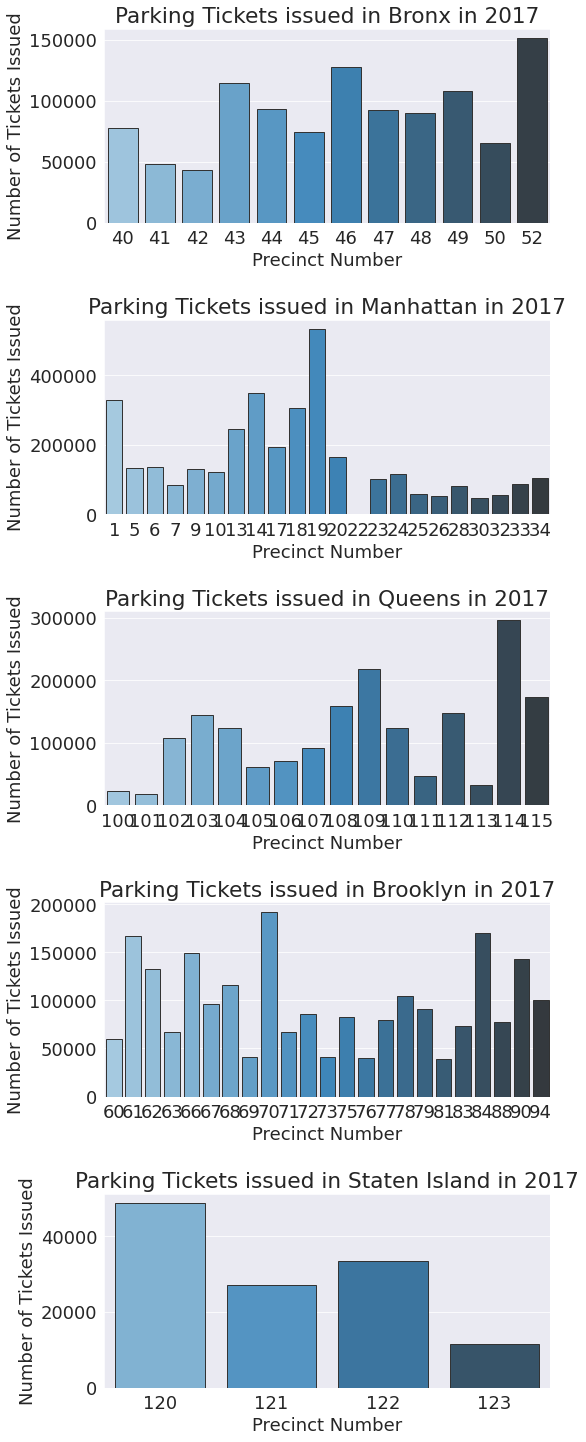

In [45]:
fig, ax = plt.subplots(nrows=len(counties), ncols=1, figsize=(8,25))

# Each loop creates one subplot
for index, county in enumerate(counties):
    county_df = df['Violation Location'][(df['Violation County'] == county) & 
                                         (df['Violation Location'].isin(precinct_dict[county])) &
                                         (df['Violation Location'].isin(feature_id_list))]
    sns.barplot(
        x=county_df.value_counts().index.astype('int32'), 
        y=county_df.value_counts().values, 
        palette='Blues_d', 
        saturation=0.9, 
        edgecolor='0.2', 
        ax=ax[index])
    ax[index].set_title('Parking Tickets issued in {} in 2017'.format(county))
    ax[index].set_xlabel('Precinct Number')
    ax[index].set_ylabel('Number of Tickets Issued')
    
    
fig.subplots_adjust(hspace=.5) # puts a space between all plots to allow for the axis labels and titles

**We can count the number of tickets that have valid precinct numbers for each county/borough**

In [46]:
count = 0
for index, county in enumerate(counties):
    count += df['Violation Location'][(df['Violation County'] == county) & 
                                         (df['Violation Location'].isin(precinct_dict[county])) &
                                         (df['Violation Location'].isin(feature_id_list))].count()

**By filtering out the valid precincts per county we lost only 44,619 of the tickets**
- can come back and see if this number changes once we evaluate the correlation between the precinct and the Issuing Agency
- This only fileters out 0.5% of the non-NaN data

In [47]:
precinct_numb_df['counts'].sum() - count

44619

In [48]:
(precinct_numb_df['counts'].sum() - count) / precinct_numb_df['counts'].sum() *100

0.5112222794333486

**Additionally we can plot the number of tickets issued in each precinct on a cloropleth map in Folium**
- We use the geojson we imported from the opendata website
- We also use the grouped df for the precinct info that will match with the json index

In [49]:
m = folium.Map(location=[40.730610, -73.935242], tiles='CartoDBpositron', zoom_start=10.5)

folium.Choropleth(
        geo_data=precinct_geo,                       # The geojson files from NYC open data
        name="choropleth",
        data=precinct_numb_df,                       # our grouped DF
        columns=["Violation Location", 'counts'],    # "Violation Location" aligns with feature.properties below
        key_on='feature.properties.precinct',        #  location that aligns with precinct
        fill_color="YlGnBu",
        fill_opacity=0.9,
        line_opacity=0.2,
        legend_name="Tickets issued 2017",
       
    ).add_to(m)

folium.LayerControl().add_to(m)
m

Output hidden; open in https://colab.research.google.com to view.

In [50]:
rank = pd.DataFrame(df[df['Violation Location'].isin(feature_id_list)][['Violation Location', 'Violation County']].value_counts()).head(10)
rank

,,0
Violation Location,Violation County,
19.0,Manhattan,532980
14.0,Manhattan,350592
1.0,Manhattan,329807
18.0,Manhattan,305438
114.0,Queens,295465
13.0,Manhattan,245902
109.0,Queens,217486
17.0,Manhattan,192550
70.0,Brooklyn,192160


## We can see 6 out of top ticket issuing precincts are in Manhattan
- Precinct 19 far outshines all other precincts -- it is an area called the "Upper East Side" with over 532,000 tickets issued in 2017 alone
- [xxx] We can return to this point and explore what this is about and what the distribution of tickets are for this precinct 19 location
- The lowest distribution of tickets is also in Manhattan - precinct 22, with only 700 tickets issues for the year.  This makes sense as it is a park, and cars are not allowed in the park -- so tickets here would be rare.  
- [xxx] Something to improve her would be to get a pop-up when mousing over each precinct with the precinct number and the corresponding number of tickets



---



# Q3 - Is there a particular month that more tickets are issued in?
- Could potentially use violation county as well so will include those columns
- Will have to filter the datetime nature of the 'Issue Date and Time' column


In [51]:
#jovian.commit(project=project_name)

In [52]:
time_df = df[['Issue Date and Time', 'Violation County', 'Violation Location', 'Violation Code']].copy()
time_df 

,Issue Date and Time,Violation County,Violation Location,Violation Code
0,2016-07-10 01:43:00,Bronx,NaN,7
1,2016-07-08 16:00:00,Bronx,NaN,7
2,2016-08-23 14:33:00,Bronx,NaN,5
3,2017-06-14 11:20:00,Manhattan,14.0,47
4,2016-11-21 17:55:00,Manhattan,13.0,69
...,...,...,...,...
10803023,2068-11-02 12:07:00,Brooklyn,68.0,21
10803024,2069-07-12 07:50:00,Brooklyn,71.0,20
10803025,2069-08-14 11:50:00,Brooklyn,69.0,46
10803026,2069-11-15 03:19:00,Brooklyn,69.0,40


**Let us now look at the range of dates that are valid for the fscal year of 2017**
- The year runs from July 1st 2016 throught June 30th 2017

In [53]:
time_df['Issue Date and Time'].describe(datetime_is_numeric=True).T

count                         10744190
mean     2016-12-30 14:38:43.664040704
min                1972-03-30 17:55:00
25%                2016-09-30 11:09:00
50%                2017-01-03 14:18:00
75%                2017-04-03 13:06:00
max                2069-11-19 08:43:00
Name: Issue Date and Time, dtype: object

**The range of dates is totally off so let us fiter them using a mask**

In [54]:
mask = (time_df['Issue Date and Time'] >= '2016-07-01') & (time_df['Issue Date and Time'] < '2017-07-01')
time_df = time_df.loc[mask].copy()
time_df['Issue Date and Time'].describe(datetime_is_numeric=True)[['min', 'max']].T

min    2016-07-01 00:00:00
max    2017-06-30 20:40:00
Name: Issue Date and Time, dtype: object

**Now let us use the datetime stamp as an index and sort it**

In [55]:
time_df = time_df.set_index('Issue Date and Time', drop=True, append=False, inplace=False, verify_integrity=False).sort_index()

In [56]:
time_df

,Violation County,Violation Location,Violation Code
Issue Date and Time,,,
2016-07-01 00:00:00,Manhattan,23.0,46
2016-07-01 00:01:00,Queens,110.0,91
2016-07-01 00:01:00,Queens,NaN,7
2016-07-01 00:03:00,Brooklyn,NaN,7
2016-07-01 00:03:00,Manhattan,NaN,7
...,...,...,...
2017-06-30 12:27:00,Brooklyn,83.0,21
2017-06-30 12:29:00,Brooklyn,83.0,21
2017-06-30 16:06:00,Manhattan,13.0,40


**We can use resample to look at the tickets issued by month** 




In [57]:
month_df = pd.DataFrame(time_df.resample('M').count()['Violation Code']) #it does not matter which column we count... 
month_df

,Violation Code
Issue Date and Time,
2016-07-31,695164
2016-08-31,796125
2016-09-30,955493
2016-10-31,964427
2016-11-30,895068
2016-12-31,774056
2017-01-31,872972
2017-02-28,822401
2017-03-31,959749


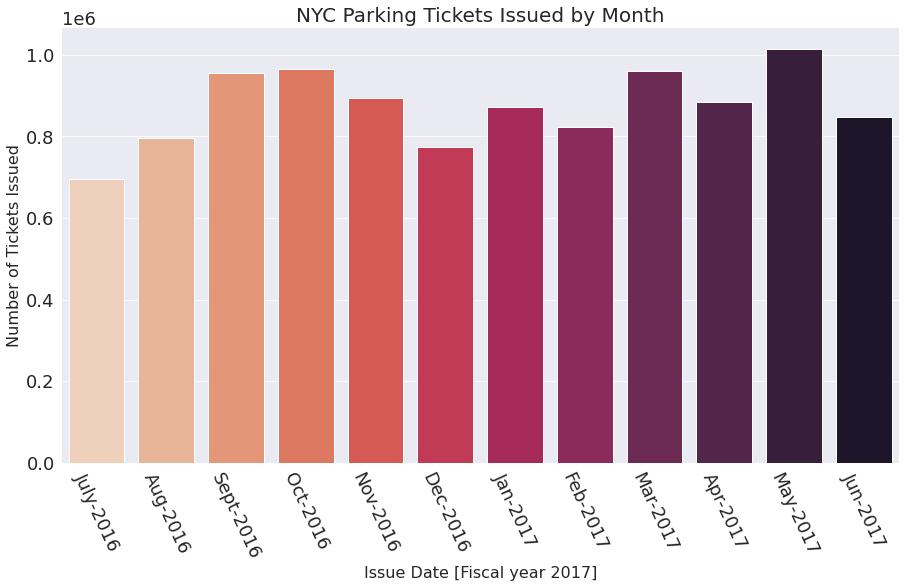

In [58]:
plt.figure(figsize=(15, 8))
ax = sns.barplot(x=month_df.index,
                  y='Violation Code',
                  data=month_df,
                  palette= 'rocket_r', #Color Brewer color schemes
                 )
ax.set_xticklabels(labels= ['July-2016', 'Aug-2016', 'Sept-2016','Oct-2016', 'Nov-2016', 'Dec-2016',
                             'Jan-2017','Feb-2017','Mar-2017','Apr-2017','May-2017','Jun-2017'])
plt.xticks(rotation=-65)
plt.xlabel('Issue Date [Fiscal year 2017]', fontsize=16)
plt.ylabel('Number of Tickets Issued', fontsize=16)
plt.title('NYC Parking Tickets Issued by Month', fontsize=20);
sns.despine(top=True, right=True, left=True, bottom=True)

## There is not a hugely dominant month that stands out in this data
- We see that May has highest value with just over 1 Million tickets issued for the month.
- July has the lowest number, with nearly 700,000 tickets issued  - Perhaps as a result of people vacationing



---



# Q4 - What days of the week are most tickets issued?  
- We will continue to use the time_df dataframe and create grouped a day-of-week dataframe

In [102]:
#jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/samantha-roberts/nyc-parking-2017-final


'https://jovian.ai/samantha-roberts/nyc-parking-2017-final'

In [60]:
day_df = (time_df.groupby(by= time_df.index.floor('D')) # Retain date row but floor index to day
                         .agg(number_of_tickets = ('Violation Code', lambda x: x.count())))

In [61]:
day_df

,number_of_tickets
Issue Date and Time,
2016-07-01,31154
2016-07-02,19079
2016-07-03,7147
2016-07-04,5055
2016-07-05,23757
...,...
2017-06-26,19839
2017-06-27,31329
2017-06-28,8


**Now use the "DayofWeek" timestamp property to see how tickets are distributed over a 7 day week**

Text(0.5, 1.0, 'Average tickets issued by day of the week')

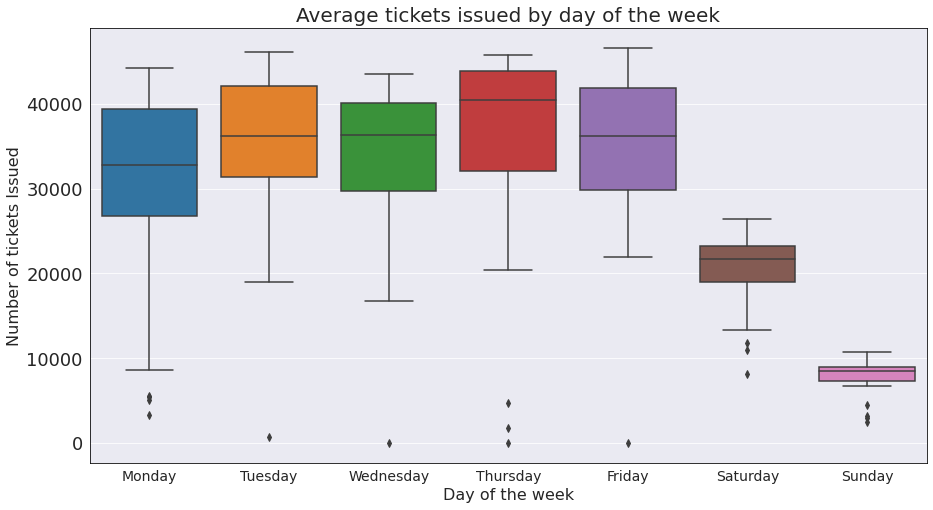

In [62]:
plt.figure(figsize=(15, 8))
sns.set_style({'axes.linewidth': 2, 'axes.edgecolor':'black'}) #this adds the black line box (spine) around the plot
ax = sns.boxplot(x=day_df.index.dayofweek, y= 'number_of_tickets', data= day_df)
ax.set_xticklabels(labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], fontsize=14)
ax.set_xlabel('Day of the week', fontsize=16)
ax.set_ylabel('Number of tickets Issued', fontsize=16)
ax.set_title('Average tickets issued by day of the week', fontsize=20)

## In the plot we see that Monday through Friday there are approximately 35,000 tickets issued daily
- Thursday takes the lead with a mean value of over 40,000 ticklets issued throughout the city
- Both weekend days have onsideable less tickets issued
- On Sundays there is an average of less than 10,000 tickets issued 



---



# Q5 - What hours of the day are most tickets issued?
- Seperate results by violation county
- Display results in a heatmap
- Use unstack after groupby operation to get equilivalent of a pivot table

In [63]:
#jovian.commit(project=project_name)

In [64]:
hour_df = time_df.groupby([time_df.index.hour, 'Violation County'])['Violation Code'].count().unstack().T
hour_df.head(10)

Issue Date and Time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Violation County,,,,,,,,,,,,,,,,,,,,,,,,
Bronx,5434,17110,14732,12239,6368,23759,41728,67925,124225,131048,110582,137540,132097,130225,94636,60162,72058,41311,17031,7701,15932,19560,17805,13423
Brooklyn,11241,36671,27694,23773,8273,12833,44605,126834,297054,355878,276032,377781,332775,278995,232003,153839,135572,93817,49449,14340,21529,31369,27311,15432
Manhattan,9690,18868,13454,8937,5073,24913,83257,207274,302138,375879,325023,331325,267028,377201,316638,225483,188727,161926,92544,13178,36716,31232,20496,16704
Queens,8024,18461,21697,17075,7491,19794,60463,103755,234565,257996,207801,237042,212223,242412,223587,144518,161799,102978,48110,18556,28454,31532,20011,13362
Staten Island,840,975,779,682,549,531,1463,11268,26277,32284,32651,26051,21678,23521,19218,15735,13223,9843,5482,2061,1399,1232,1187,809


In [65]:
fig = px.imshow(hour_df, 
                color_continuous_scale='Viridis', 
                zmin=-50000, 
                zmax=375000)
fig.update_layout(
    title={
          'text': 'Parking tickets issued in NYC by time of day',
          'y':0.97,
          'x':0.5,
          'xanchor': 'center',
          'yanchor': 'top'
    },
    yaxis_title='Violation Borough',
    xaxis_title='Violation Time',
    #xgap=1, 
    #ygap=1,
    #boxgap=1,
    #annotations=({'Issue Date and Time': 'Hour of Day'}),
    font=dict(
        family="ariel", #"Courier New, monospace",
        size=16,
        color="RebeccaPurple"
    )
)

fig.update_xaxes(
    ticktext=[str(i)+' AM' if i != 0 else '12 AM' for i in list(range(12))] + 
             [str(i)+' PM' if i != 0 else '12 PM' for i in list(range(12))],
    tickvals=[str(i) for i in list(range(24))])
fig.update_yaxes(
    ticktext=list(hour_df.index.categories),
    tickvals=[0, 1, 2, 3, 4])
fig.show()

## We see that the hours between 6AM and 6PM are when the most tickets are issued 
- This trend is consistent across all of the 5 boroughs
- In this heatmap Staten Island is outstanding in that it has comparatively few tickets being issued no matter what time of day it is 



---



# Q6 - What is the overall income that NYC makes on tickets?
- We first need to retrieve a csv file from NYC Open data which has violation descriptions and fines for each of the violation codes in our current data
- we will then need to rename the columns and merge the two dataframes
- For now we will only use the std fine -- the increased fine (below 96th street) involved finding the locatiion of manhattan tickets which is currently beyond the scope of this EDA


In [66]:
#jovian.commit(project=project_name)

**The file below will have the codes, the definition, and the associated fine**

In [67]:
violation_defs_and_fines = pd.read_csv('https://data.cityofnewyork.us/api/views/ncbg-6agr/rows.csv?accessType=DOWNLOAD')
violation_defs_and_fines

,CODE,DEFINITION,Manhattan 96th St. & below,All Other Areas
0,1,FAILURE TO DISPLAY BUS PERMIT,515,515
1,2,NO OPERATOR NAM/ADD/PH DISPLAY,515,515
2,3,UNAUTHORIZED PASSENGER PICK-UP,515,515
3,4,BUS PARKING IN LOWER MANHATTAN,115,115
4,5,BUS LANE VIOLATION,50,50
...,...,...,...,...
92,93,REMOVE/REPLACE FLAT TIRE,65,65
93,96,RAILROAD CROSSING,95,95
94,97,VACANT LOT,65,45
95,98,OBSTRUCTING DRIVEWAY,95,95


**We see we also have up to 99 violation code values in the Tickets issued DF**
- This appears to include 0, not a valid violation code

In [68]:
np.sort(df['Violation Code'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [69]:
df["Violation Code"].isna().sum()

0

In [70]:
df.head(3)

,Registration State,Plate Type,Violation Location,Issuer Precinct,Issuer Code,Violation Code,Meter Number,Violation County,Issuer Squad,Issuing Agency,Issue Date and Time
0,NY,PAS,NaN,0,0,7,NaN,Bronx,NaN,V,2016-07-10 01:43:00
1,NY,PAS,NaN,0,0,7,NaN,Bronx,NaN,V,2016-07-08 16:00:00
2,NY,PAS,NaN,0,0,5,NaN,Bronx,NaN,V,2016-08-23 14:33:00


**We rename the column of the new 'Violation Code' dataframe**
- Make certain the the 'Violation Code' column matches the header of our 2017 tickets issued dataframe

In [71]:
violation_defs_and_fines.columns = ['Violation Code', 'Violation Description', 'Fine (below 96th)', 'Fine']
violation_defs_and_fines.columns

Index(['Violation Code', 'Violation Description', 'Fine (below 96th)', 'Fine'], dtype='object')

In [72]:
merged_df = pd.merge(df, violation_defs_and_fines, on='Violation Code', how='left')

In [73]:
merged_df.sample(5)

,Registration State,Plate Type,Violation Location,Issuer Precinct,Issuer Code,Violation Code,Meter Number,Violation County,Issuer Squad,Issuing Agency,Issue Date and Time,Violation Description,Fine (below 96th),Fine
9499950,NY,SRF,NaN,0,0,7,NaN,Queens,NaN,V,2017-04-03 07:11:00,FAILURE TO STOP AT RED LIGHT,50.0,50.0
1756446,NY,PAS,NaN,0,0,36,NaN,Bronx,NaN,V,2016-12-20 14:59:00,PHTO SCHOOL ZN SPEED VIOLATION,50.0,50.0
511724,PA,PAS,61.0,61,361096,37,334-3038,Brooklyn,B,T,2016-09-07 11:43:00,EXPIRED MUNI METER,65.0,35.0
9670329,VA,PAS,30.0,30,361889,40,NaN,Manhattan,AA,T,2017-02-21 06:06:00,FIRE HYDRANT,115.0,115.0
631955,NY,PAS,NaN,0,0,7,NaN,Bronx,NaN,V,2017-05-13 15:26:00,FAILURE TO STOP AT RED LIGHT,50.0,50.0


In [74]:
merged_df.Fine.sum()

742255665.0

## The total fines ticketed amount to $742 million dollars across all 5 boroughs!



---





# Q7 What is the breakdown of fines across boroughs and precincts?
- first we get a DF with the borough, precinct, violation description, and the fine
- create a pie chart with dollars and percentages
- create a treemap with city/boroughs/precincts

In [75]:
fine_df = merged_df[['Violation Location', 'Violation County', 'Violation Description', 'Fine']].copy()

In [76]:
fine_df

,Violation Location,Violation County,Violation Description,Fine
0,NaN,Bronx,FAILURE TO STOP AT RED LIGHT,50.0
1,NaN,Bronx,FAILURE TO STOP AT RED LIGHT,50.0
2,NaN,Bronx,BUS LANE VIOLATION,50.0
3,14.0,Manhattan,DOUBLE PARKING-MIDTOWN COMML,115.0
4,13.0,Manhattan,FAIL TO DISP. MUNI METER RECPT,35.0
...,...,...,...,...
10803023,68.0,Brooklyn,NO PARKING-STREET CLEANING,45.0
10803024,71.0,Brooklyn,NO PARKING-DAY/TIME LIMITS,60.0
10803025,69.0,Brooklyn,DOUBLE PARKING,115.0
10803026,69.0,Brooklyn,FIRE HYDRANT,115.0


In [77]:
fine_totals = pd.DataFrame(fine_df.groupby('Violation County')['Fine'].sum().sort_values(ascending=False))
fine_totals 

,Fine
Violation County,
Manhattan,284662405.0
Brooklyn,192412615.0
Queens,154344590.0
Bronx,91671815.0
Staten Island,15490080.0


In [78]:
fine_totals.sum()

Fine    738581505.0
dtype: float64

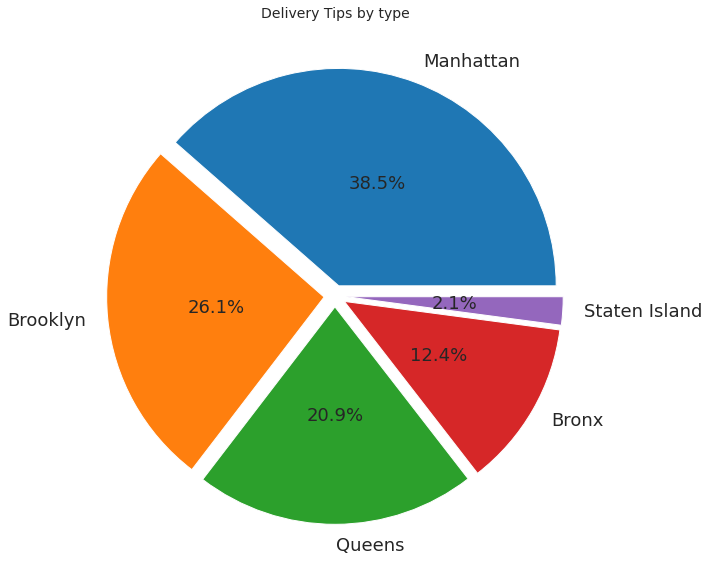

In [79]:
pie, ax = plt.subplots(figsize=[10,10])
plt.pie(x=np.array(fine_totals.values).ravel(), autopct="%.1f%%", explode=[0.05]*5, labels=fine_totals.index, pctdistance=0.5)
plt.title("Delivery Tips by type", fontsize=14);

**We now need to drop all the NaN rows because px.treemap can not tolerate them**
- Treemap will show the breakdown of fines for each precinct in each borough of NYC
- This will take over 2 minutes to run with 24G of RAM

In [80]:
#we need to drop the NaN rows here because px.treemap can not tolerate them
fine_precinct_df = fine_df.dropna(subset=['Violation Location', 'Violation County']).copy() 
#need to make this a string so the values can be compared witht the valied precincts 
fine_precinct_df['Violation Location'] = fine_precinct_df['Violation Location'].astype('int').astype('str')
# we select out only the valid precinct numbers 
fine_precinct_df = fine_precinct_df[fine_precinct_df['Violation Location'].isin(feature_id_list)] 
fine_precinct_df.sample(5)

,Violation Location,Violation County,Violation Description,Fine
4521034,44,Bronx,SIDEWALK,115.0
5925190,6,Manhattan,EXPIRED MUNI METER,35.0
7959400,70,Brooklyn,FAIL TO DSPLY MUNI METER RECPT,35.0
1444146,19,Manhattan,FAIL TO DSPLY MUNI METER RECPT,35.0
6229846,60,Brooklyn,NO PARKING-STREET CLEANING,45.0


In [81]:
%%time
fig = px.treemap(fine_precinct_df, 
                 path=[px.Constant("NYC"), 'Violation County', 'Violation Location'], 
                 values='Fine',
                )
fig.update_traces(root_color="darkgrey")
fig.update_layout(margin = dict(t=50, l=50, r=50, b=50),
                  uniformtext_minsize=14, 
                  uniformtext_mode='hide')
fig.show()

CPU times: user 2min 4s, sys: 2.45 s, total: 2min 7s
Wall time: 2min 6s


## The pie chart shows the percentage breakdowns of each borough, and hovering over the treemap shows the breakdown for the whole of NYC, for each borough, and for each precinct.
- [xxx] Want to be able to put the value for the dollar sum in each wedge of the chart



---



# Q8 What are the most common reasons tickets are issued?
- Will need the merged dataframe with the violation descriptions
- Will need to group in a useful way for plotting
- Can try to correlate these numbers with the bourough/county

In [166]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/samantha-roberts/nyc-parking-2017-final


'https://jovian.ai/samantha-roberts/nyc-parking-2017-final'

In [83]:
fine_precinct_df.head()

,Violation Location,Violation County,Violation Description,Fine
3,14,Manhattan,DOUBLE PARKING-MIDTOWN COMML,115.0
4,13,Manhattan,FAIL TO DISP. MUNI METER RECPT,35.0
6,71,Brooklyn,FIRE HYDRANT,115.0
10,106,Queens,NGHT PKG ON RESID STR-COMM VEH,65.0
11,18,Manhattan,NO STANDING-BUS STOP,115.0


**Let us group and then unstack back into a dataframe**
- note that this just is another way of making a pivot table

In [84]:
violation_df = merged_df.groupby(['Violation Description', 'Violation County'])['Violation Location'].count()
violation_df = violation_df.unstack()
violation_df.head()

Violation County,Bronx,Brooklyn,Manhattan,Queens,Staten Island
Violation Description,,,,,
ALTERING INTERCITY BUS PERMIT,5,10,21,9,1
ANGLE PARKING,1723,1211,2237,1444,54
ANGLE PARKING-COMM VEHICLE,56,24,133,17,0
BEYOND MARKED SPACE,843,2151,786,1360,496
BIKE LANE,13265,13201,50489,6089,170


In [163]:
violation_df.sum()

Violation County
Bronx            1087653
Brooklyn         2217189
Manhattan        3428597
Queens           1837823
Staten Island     121307
sum              8692569
dtype: int64

In [164]:
merged_df.shape[0]

10803028

**Now we want to sum scross the counties to get the total of each ticket issued 
- we then sort the dataframe according to this total sum
- We do not want to loose the individual county information so we can still deliniate by county in the plot

In [85]:
violation_df.columns = violation_df.columns.add_categories(['sum'])
violation_df['sum'] = violation_df.sum(axis=1)
violation_df.sort_values(by='sum', ascending=False, axis=0, inplace=True)
violation_df.head()

Violation County,Bronx,Brooklyn,Manhattan,Queens,Staten Island,sum
Violation Description,,,,,,
NO PARKING-STREET CLEANING,229009,661076,290891,341281,72,1522329
FAIL TO DSPLY MUNI METER RECPT,129723,297750,309660,307585,17089,1061807
NO STANDING-DAY/TIME LIMITS,60601,163224,519579,135356,10177,888937
NO PARKING-DAY/TIME LIMITS,94707,153716,208465,152375,6051,615314
EXPIRED MUNI METER,63859,116397,234948,175086,6324,596614


**Now that the table is sorted we create a dataframe to plot with the sum excluded**
- we only incude the top 30 of 97 types of tickets

In [86]:
plot_df = violation_df.drop(columns='sum')
plot_df = plot_df.head(30)

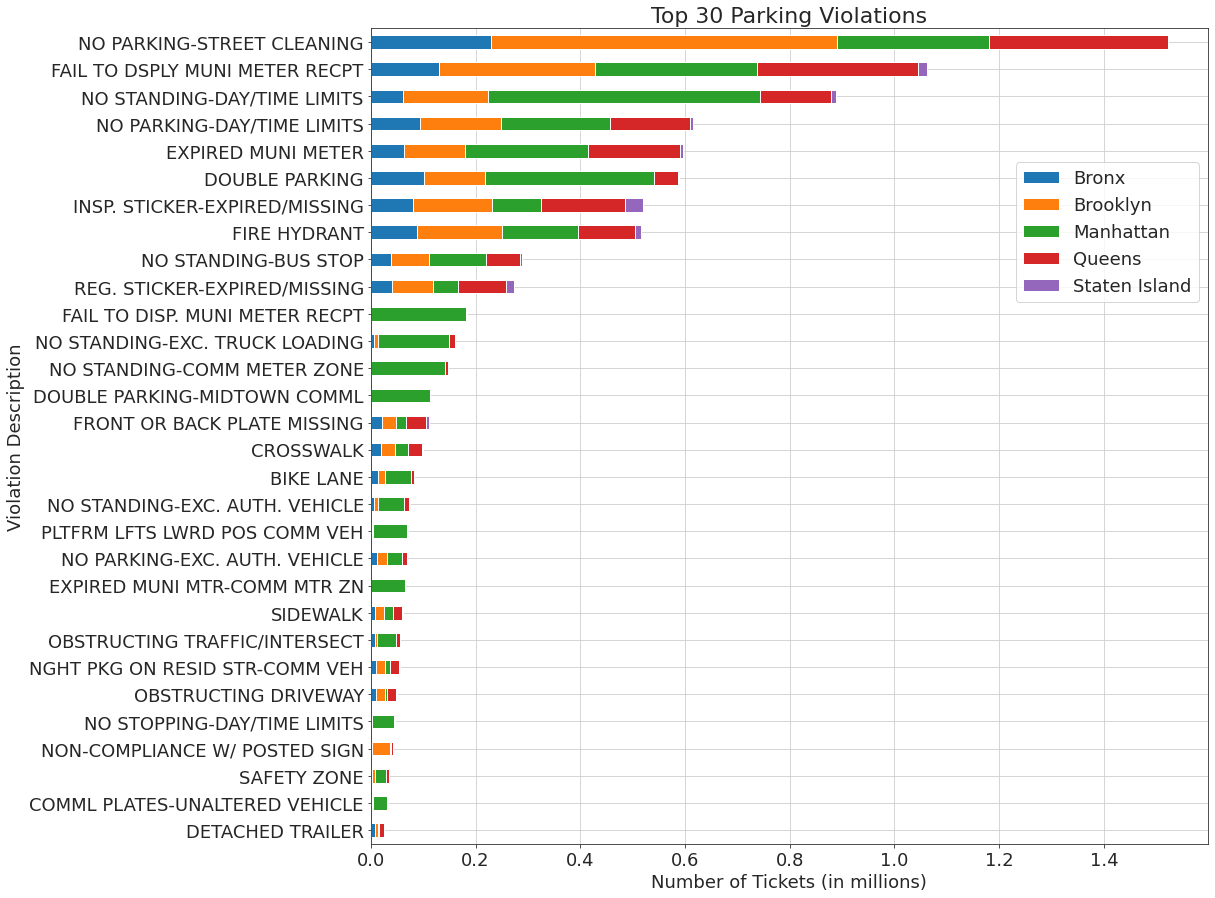

In [165]:
from matplotlib.ticker import FuncFormatter

def millions_formatter(x, pos):
    return f'{x / 1000000}'

ax = plot_df.plot.barh(rot=0, stacked=True, sort_columns=True, figsize=(15,15))
ax.invert_yaxis()
ax.set_title("Top 30 Parking Violations", fontsize=22);
ax.set_ylabel("Violation Description", fontsize=18)
ax.xaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax.set_xlabel('Number of Tickets (in millions)', fontsize=18)
ax.legend(loc='center right', bbox_to_anchor=(1, 0.75), frameon=True, fontsize=18)
plt.show()

## We see the most common tickets are for street cleaning and are also issued at expired meters
- [xxx] One thing I note is in the data before eliminating the NaN for precinct and county there were a high amount of non-parking related tickets - these are issued by cameras set up at different intersections and school zones to monitor speed.  These are noteworthy because they are not parking tickets but are in this data.  
- return to this and explore the magnitude of this contribution

**However I remember there being camera violations that ranked high in the raw data - Lets go back and check that out**

In [112]:
temp = merged_df.groupby('Violation Description')['Fine'].sum()

In [123]:
temp.sort_values(ascending=False)[:10]

Violation Description
NO STANDING-DAY/TIME LIMITS       102752270.0
PHTO SCHOOL ZN SPEED VIOLATION     70030700.0
DOUBLE PARKING                     69001380.0
NO PARKING-STREET CLEANING         68786460.0
FIRE HYDRANT                       59755725.0
FAIL TO DSPLY MUNI METER RECPT     37180640.0
NO PARKING-DAY/TIME LIMITS         37115580.0
INSP. STICKER-EXPIRED/MISSING      33885020.0
NO STANDING-BUS STOP               33455800.0
FAILURE TO STOP AT RED LIGHT       25819750.0
Name: Fine, dtype: float64

In [120]:
merged_df[['Violation Code', 'Violation Description']][merged_df['Violation Description'] == 'PHTO SCHOOL ZN SPEED VIOLATION']

,Violation Code,Violation Description
7,36,PHTO SCHOOL ZN SPEED VIOLATION
8,36,PHTO SCHOOL ZN SPEED VIOLATION
12,36,PHTO SCHOOL ZN SPEED VIOLATION
19,36,PHTO SCHOOL ZN SPEED VIOLATION
35,36,PHTO SCHOOL ZN SPEED VIOLATION
...,...,...
10764507,36,PHTO SCHOOL ZN SPEED VIOLATION
10764508,36,PHTO SCHOOL ZN SPEED VIOLATION
10764509,36,PHTO SCHOOL ZN SPEED VIOLATION
10764510,36,PHTO SCHOOL ZN SPEED VIOLATION


In [124]:
merged_df[['Violation Code', 'Violation Description']][merged_df['Violation Description'] == 'FAILURE TO STOP AT RED LIGHT']

,Violation Code,Violation Description
0,7,FAILURE TO STOP AT RED LIGHT
1,7,FAILURE TO STOP AT RED LIGHT
5,7,FAILURE TO STOP AT RED LIGHT
16,7,FAILURE TO STOP AT RED LIGHT
90,7,FAILURE TO STOP AT RED LIGHT
...,...,...
10797214,7,FAILURE TO STOP AT RED LIGHT
10797215,7,FAILURE TO STOP AT RED LIGHT
10797216,7,FAILURE TO STOP AT RED LIGHT
10797217,7,FAILURE TO STOP AT RED LIGHT


**so there are two kinds of tickets that are not parking violations but ARE *moving* violations**
- 516395 for Failure to stop at red light
- 1400614 for Photo School Zone speed violation 

**Let's look into these two back in the raw df and see what locations they occur at**

In [139]:
raw_df[(raw_df["Violation Code"] == 7)]['Street Name'].nunique()

167

In [140]:
raw_df[(raw_df["Violation Code"] == 7)]['Street Name'].unique()

array(['ALLERTON AVE (W/B) @', 'NORTHERN BLVD (E/B)',
       'SO CONDUIT AVE (E/B)', 'ATLANTIC AVE (E/B) @',
       'SB OCEAN PKWY @ 18TH', 'ATLANTIC AVE (W/B) @',
       'BORDEN AVE (E/B) @ G', 'WILLIAMSBURG ST (S/B',
       'BROADWAY (S/B) @ SHE', 'QUEENS BLVD (W/B) @',
       'HILLSIDE AVE (W/B) @', 'WOODHAVEN BLVD (N/B)',
       'GRAND CONCOURSE (N/B', 'NB OCEAN PKWY @ AVEN',
       '86TH ST (E/B) @ 7TH', 'NORTHERN BLVD (W/B)',
       '222ND ST (E/B) @ PAU', '23RD AVE (E/B) @ 94T',
       'WEST END AVE (S/B) @', 'KINGS HWY (S/B) @ RE',
       'VICTORY BLVD (W/B) @', '3RD AVE (N/B) @ 36TH',
       'BEACH CHANNEL DR (S/', 'KISSENA BLVD (S/B) @',
       'WHITESTONE EXPWY SVC', 'L.I.E. N. SVC ROAD (',
       'LINDEN BLVD (E/B) @', 'E 135TH ST (W/B) @ A',
       'CONEY ISLAND AVE (S/', '5TH AVE (S/B) @ 40TH',
       '39TH ST (N/B) @ NORT', 'VAN WYCK EXP SVC RD',
       'FRANCIS LEWIS BLVD (', 'CROSS BRONX EXPWY (W',
       'PENNSYLVANIA AVE (N/', 'GUN HILL ROAD (W/B)',
       'WB N COND

In [157]:
raw_df[(raw_df["Violation Code"] == 7)]['Street Name'].value_counts().head(15)


HORACE HARDING EXPWY    28373
ATLANTIC AVE (E/B) @    23486
ATLANTIC AVE (W/B) @    18069
NORTHERN BLVD (E/B)     17213
QUEENS BLVD (W/B) @     15761
QUEENS BLVD (E/B) @     12150
ASTORIA BLVD S (E/B)    11671
FLATBUSH AVE (N/B) @    10338
BEACH CHANNEL DR (W/    10268
HAMILTON AVE (N/B) @     9511
EASTERN PKWY (W/B) @     8802
OCEAN PKWY (N/B) @ A     8190
EB GRAND CENTRAL PKW     8105
WOODHAVEN BLVD (N/B)     8012
CONEY ISLAND AVE (S/     7569
Name: Street Name, dtype: int64

In [161]:
raw_df[(raw_df["Violation Code"] == 7)]['Violation County'].value_counts()

QN    212340
BK    178920
BX     53840
ST     40678
MN     30610
NY         6
K          1
Name: Violation County, dtype: int64

In [149]:
raw_df[(raw_df["Violation Code"] == 36)]['Street Name'].nunique()

731

In [156]:
raw_df[(raw_df["Violation Code"] == 36)]['Street Name'].value_counts().sum()

1400614



---



# Q9 What is the breakdown of 'Issuing Agencies' in the data?  
- For This we need to scrape the [NYC Open Data Website](https://data.cityofnewyork.us/City-Government/Parking-Violations-Issued-Fiscal-Year-2021/pvqr-7yc4).  2021 is apparently the only year where the data description lists the agencies and their abbreviations.  (The data CSV's only contain the abreviations)
- We will use the BeautifulSoup library to parse the HTML **(Need Selenium)!**

- We will then convert the text into a pandas dataframe 
- We will merge this with our 'Tickets Issued' and 'Violationn Fines' dataframe for analysis

In [88]:
# from bs4 import BeautifulSoup
# import requests

# parking_violations_url = 'https://data.cityofnewyork.us/City-Government/Parking-Violations-Issued-Fiscal-Year-2021/pvqr-7yc4'
# soup = BeautifulSoup(requests.get(parking_violations_url).text)
# soup.find_all('table')#, class_='wikitable sortable plainrowheaders')

**For now (until I can scrape the above page with Selenium), I will manually copy pase the text string in**
- We can then read it into a pandas dataframe using io.StringIO

In [89]:
import io

web_text = 'A-PORT AUTHORITY, B-TRIBOROUGH BRIDGE AND TUNNEL POLICE, C-CON RAIL, D-DEPARTMENT OF BUSINESS SERVICES, E-BOARD OF ESTIMATE, F-FIRE DEPARTMENT, G-TAXI AND LIMOUSINE COMMISSION, H-HOUSING AUTHORITY, I-STATEN ISLAND RAPID TRANSIT POLICE, J-AMTRAK RAILROAD POLICE, K-PARKS DEPARTMENT, L-LONG ISLAND RAILROAD, M-TRANSIT AUTHORITY, N-NYS PARKS POLICE, O-NYS COURT OFFICERS, P-POLICE DEPARTMENT, Q-DEPARTMENT OF CORRECTION, R-NYC TRANSIT AUTHORITY MANAGERS, S-DEPARTMENT OF SANITATION, T-TRAFFIC, U-PARKING CONTROL UNIT, V-DEPARTMENT OF TRANSPORTATION, W-HEALTH DEPARTMENT POLICE, X-OTHER/UNKNOWN AGENCIES, Y-HEALTH AND HOSPITAL CORP. POLICE, Z-METRO NORTH RAILROAD POLICE, 1-NYS OFFICE OF MENTAL HEALTH POLICE, 2-O M R D D, 3-ROOSEVELT ISLAND SECURITY, 4-SEA GATE ASSOCIATION POLICE, 5-SNUG HARBOR CULTURAL CENTER RANGERS, 6-WATERFRONT COMMISSION OF NY HARBOR, 7-SUNY MARITIME COLLEGE, 9-NYC OFFICE OF THE SHERIFF'
issuing_agency_df = pd.read_csv( io.StringIO(web_text), sep=',', header=None).T.rename(columns={0: 'Agency'})
issuing_agency_df = pd.DataFrame(issuing_agency_df.Agency.str.split('-',1).tolist(),
                                 columns = ['Issuing Agency','Agency Name'])
issuing_agency_df['Issuing Agency'] = issuing_agency_df['Issuing Agency'].str.strip() # Sees to still be whitespace so cnt merge properly
issuing_agency_df

,Issuing Agency,Agency Name
0,A,PORT AUTHORITY
1,B,TRIBOROUGH BRIDGE AND TUNNEL POLICE
2,C,CON RAIL
3,D,DEPARTMENT OF BUSINESS SERVICES
4,E,BOARD OF ESTIMATE
5,F,FIRE DEPARTMENT
6,G,TAXI AND LIMOUSINE COMMISSION
7,H,HOUSING AUTHORITY
8,I,STATEN ISLAND RAPID TRANSIT POLICE
9,J,AMTRAK RAILROAD POLICE


In [90]:
merged_df2 = pd.merge(merged_df, issuing_agency_df, on='Issuing Agency', how='left')

In [95]:
agency_totals_df = pd.DataFrame(merged_df2['Agency Name'].value_counts())
agency_totals_df = agency_totals_df.head(5)

In [100]:
fig = px.bar(agency_totals_df, 
             x='Agency Name',
             y=agency_totals_df.index,
             width=800,
             height=600
            )
fig['layout']['yaxis']['autorange'] = "reversed"
fig.update_layout(title='NYC Parking Tickets Issued in 2017 by Agency (Totals of all Boroughs)', 
                  xaxis_title='Number of Tickets (In Millions)',
                  yaxis_title='Issuing Agency')
fig.show()

In [98]:
temp = pd.DataFrame(merged_df2.groupby(['Agency Name', 'Violation County'])['Plate Type'].count().reset_index())
temp2 = temp.groupby(['Agency Name', 'Violation County'])['Plate Type'].sum().sort_values(ascending=False)
temp3 = pd.DataFrame(temp2).head(19)
temp4 = temp3.reset_index()
temp4

,Agency Name,Violation County,Plate Type
0,TRAFFIC,Manhattan,3123509
1,TRAFFIC,Brooklyn,1815757
2,TRAFFIC,Queens,1663576
3,TRAFFIC,Bronx,900890
4,DEPARTMENT OF TRANSPORTATION,Brooklyn,880656
5,DEPARTMENT OF TRANSPORTATION,Queens,674245
6,DEPARTMENT OF TRANSPORTATION,Bronx,273903
7,POLICE DEPARTMENT,Manhattan,267041
8,POLICE DEPARTMENT,Brooklyn,238673
9,DEPARTMENT OF SANITATION,Brooklyn,159088


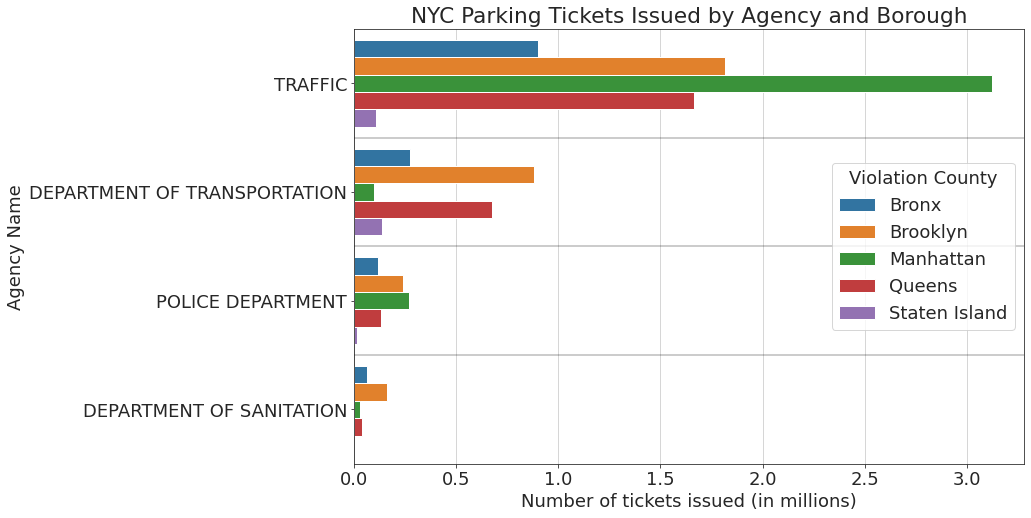

In [99]:
from matplotlib.ticker import FuncFormatter

def millions_formatter(x, pos):
    return f'{x / 1000000}'
plt.figure(figsize=(12, 8))
sns.set_style("ticks",{'axes.grid' : True})
ax = sns.barplot(x='Plate Type', y='Agency Name', hue='Violation County', data=temp4)
ax.set_xlabel('Number of tickets issued (in millions)', fontsize=18)
ax.set_ylabel('Agency Name', fontsize=18)
ax.xaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax.set_title('NYC Parking Tickets Issued by Agency and Borough');
ax.axhline(0.5, color='black', linewidth=0.4) # somehow this will not let me specify all y positions in a single list
ax.axhline(1.5, color='black', linewidth=0.4)
ax.axhline(2.5, color='black', linewidth=0.4);

In [101]:
print('4 agencies issue {:.2f} percent of all NYC parking tickets'.format(temp4["Plate Type"].sum() / merged_df2.shape[0] *100))

4 agencies issue 99.35 percent of all NYC parking tickets


## 4 NYC agencies issue 99.35% of all NYC tickets (even though there are 34 agencies total)
- Manhattan is ticket almost exclusivly by the traffic agency and police departments
- Brooklyn and Queens are also heavily ticketed by the Department of Transportation  





---



# Summary of EDA
1. We have downloaded a dataset from Kaggle with over 10 million rows and 43 columns
2. We have chosen select columns, which allow us to evaluate:
  - The breakdown in date and date and time when ticckets are frequently issued
  - The breakdown according to the NYC counties/Boroughs
  - The breakdown according to the police precincts
  - The annual income NYC stands to make from these tickets
  - The geographic location that tickets are issued in
  - The type of tickets that frequently get issued
3. We used 11 graphs (**including: Pie charts, histograms, barcharts (standard, horizontal and stacked), chart with sub plots, treemap, heatmap, choropleth map and boxplots**) as well as Dataframe tables to answer and explore the data utilizing the following libraries:
  - Matplotlib
  - Seaborn
  - Plotly
  - Seaborn
  - Folium
  - Pandas
4. We were able to include extrenanal data from NYC Open Data to do the following:
  - Download a geojson file which gives the geographic perimeters of all 77 NYC police precints.  
  - This allowed the creation of a choropleth map that indicated the precincts and their geographic location as a function of how many annual tickets are issued there.
  - Downloaded a csv file that corelated the Violation Code on the ticket with the Violation description and the associated fine



---



# Future Work
1. import the remaining 4 years of Kaggle data and analysis it using this same code
2. Create a notebookthat can directly download the data from NYC Open Data and also retrieve the years of data not yet on Kaggle, namely 2018, 2019, 2020, and 2021
3. The 2020 and 2021 data is particularly relevant for looking at the impact of COVID on NYC, which was an initial hotspot.
  - Beginning March of 2020 the city was shut down and parking violations were largely suspended for several months.  
4. There is a region that has extremely high ticket activity, which is precinct 19, an area of Manhattan known as "The Upper East Side"
  - Exploration of the different types of tickets issued here and the ticketing agents would potentially be interesting.
5. Scrape the NYC Open Data page to get the descriptors for the 'Issuer Squad" column codes
  - Look to see if the squad division affects the precincts, and could possibly explain all the the precinct numbers that far exceed the valid police precincts.
6. Use the street address codes to do a reverse look-up of the latatitude and longitude data and see if there are specific addresses that are key hotspots for issuing tickets
7. We will apply some compression methods for massivly large data such as invoking Dask and reducing the saze of the datatypes and furthere converting to catagorical data when possible



---



# References
### Parking Violation Data on [NYC Open Data](https://data.cityofnewyork.us/browse?q=parking+violations) (Direct Links to the CSV files)<a id="CSVLinks"></a>
- [2021](https://data.cityofnewyork.us/api/views/pvqr-7yc4/rows.csv?accessType=DOWNLOAD)
- [2020](https://data.cityofnewyork.us/api/views/p7t3-5i9s/rows.csv?accessType=DOWNLOAD)
- [2019](https://data.cityofnewyork.us/api/views/faiq-9dfq/rows.csv?accessType=DOWNLOAD)
- [2018](https://data.cityofnewyork.us/api/views/a5td-mswe/rows.csv?accessType=DOWNLOAD)
- [2017](https://data.cityofnewyork.us/api/views/2bnn-yakx/rows.csv?accessType=DOWNLOAD)
- [2016](https://data.cityofnewyork.us/api/views/kiv2-tbus/rows.csv?accessType=DOWNLOAD)
- [2015](https://data.cityofnewyork.us/api/views/c284-tqph/rows.csv?accessType=DOWNLOAD)
- [2014](https://data.cityofnewyork.us/api/views/jt7v-77mi/rows.csv?accessType=DOWNLOAD)

### Department of Finance
- [Parking Violation Codes](https://data.cityofnewyork.us/Transportation/DOF-Parking-Violation-Codes/ncbg-6agr) and [Violation Code and Fines CSV](https://data.cityofnewyork.us/api/views/ncbg-6agr/rows.csv?accessType=DOWNLOAD)   

### Geographic files of Police Precincts
- Direct links to the [GeoJSON file](https://data.cityofnewyork.us/api/geospatial/78dh-3ptz?method=export&format=GeoJSON) and [Shapefile](https://data.cityofnewyork.us/api/geospatial/78dh-3ptz?method=export&format=Shapefile) formats, and the page to find [many other formats](https://data.cityofnewyork.us/Public-Safety/Police-Precincts/78dh-3ptz)



---



# Other interesting Links for NYC Parking news and NYC Open Data info
- [NYPD systematically ticketing legally parked cars](https://iquantny.tumblr.com/post/144197004989/the-nypd-was-systematically-tickeing-legally)
- [NYC-Parking Tickets An Exploratory Analysis](https://github.com/djha1208/NYC-Parking-Tickets-An-Exploratory-Analysis)
- [NYC Parking Tickets Fascinating Factoids Will Amaze You](https://newyorkparkingticket.com/nyc-parking-tickets-5/)
- [New York Times - About NYC Police Precinct Codes](https://www.nytimes.com/2017/03/17/nyregion/nypd-precincts.html)



---



# Acknowledgements
- Thank you Jovian team for your help with this -- It is a work in progress!  



---



# Notes to self:
- Here is where I will start learning Selenium: https://www.youtube.com/watch?v=bhYulVzYRng


In [147]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/samantha-roberts/nyc-parking-2017-final


'https://jovian.ai/samantha-roberts/nyc-parking-2017-final'